In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ipywidgets import widgets
import seaborn as sns
from  scipy import signal
from scipy.signal import find_peaks
from pandas import read_excel
from pandas import read_csv
import warnings; warnings.filterwarnings("ignore", category=FutureWarning)

In [17]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor 
from sklearn.model_selection import train_test_split
from time import time 

---------------------------------------------------------------------------------------------------------------------------

# Limpieza de datos

#### Headers

In [18]:
def lim_header(df):
    df.columns = df.iloc[0]
    df = df.drop(index=0)
    df.rename(columns = {"día de la semana" : "día_semana"}, inplace=True )
    df.rename(columns = {pd.NaT : "fechas"}, inplace = True)
    return df

##### Relleno día semana y fecha 

In [19]:
def lim_relleno(df):
    dia_sem = df["día_semana"].tolist()
    fech = df["fecha"].tolist()
    hor = df["hora"].tolist()
    indx = 0
    for h in hor:
        if h == 1:
            fecha = fech[indx]
            diaa = dia_sem[indx]
            indx += 1
        elif h != 1:
            fech[indx] = fecha
            dia_sem[indx] = diaa
            indx += 1
    df["fecha"] = fech
    df["día_semana"] = dia_sem
    return df

#### Remplazo de valores no numéricos

In [20]:
def lim_Nnum(df):
    df['year'] = pd.DatetimeIndex(df["fechas"]).year
    df['month'] = pd.DatetimeIndex(df["fechas"]).month
    df['day'] = pd.DatetimeIndex(df["fechas"]).day

    df = df.replace(["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"], [0, 1, 2, 3, 4, 5, 6])
    df = df.replace(["Miércoles", "Sábado"],[2,5])

    df = df.drop(["fecha","fechas"], axis=1)
    df = df.dropna()
    
    return df

#### Cambio de nombre a zonas de carga

In [21]:
def lim_nomzon(df):
    zonas = df.columns
    elim = ["día_semana", "hora", "day", "year", "month"]
    zonas = zonas.drop(elim)
    son = ["zona_{}".format(i+1) for i in range(len(zonas))]
    listDic={}
    for zona, so in zip(zonas, son):
        listDic[zona]=so
    df.rename(columns = listDic, inplace=True )
    return df

### Creación de variables "Dummies"

#### Adición de días festivos con penalización

In [22]:
def dum_fest(df):
    cata = []; fes = read_csv("festivos.csv")
    for j in range(len(fes.index)):
            festiveDay = df.loc[(df.year==fes["Year"][j]) & (df.month==fes["Month"][j]) & (df.day==fes["Day"][j])].index.values.tolist()
            cata = cata + festiveDay

    df['fest'] = np.nan; df.fest = df.fest.fillna(pd.Series(-1, index=cata))
    df.fest = df.fest.fillna(0)
    df.fest.unique()
    return df

#### Variables "Dummies" día de la semana

In [23]:
# def dum_dia(df):
#     # lunes, martes-miercoles-jueves, viernes, sabado, domingo
#     df.día_semana=df.día_semana.apply(lambda x: 1 if x==1 else (2 if x in [2,3,4] else (3 if x==5 else (4 if x==6 else 0))))
#     df = pd.get_dummies(df, prefix=['d_sm'], columns=['día_semana'])
#     df = df.drop("d_sm_0", axis = 1)
#     return df

In [24]:
def dum_dia(df):
    # lunes, martes, miercoles, jueves, viernes, sabado, domingo
    df.día_semana=df.día_semana.apply(lambda x: 1 if x==1 else (2 if x==2 else (3 if x==3 else (4 if x==4 else (5 if x==5 else (6 if x==6 else 0))))))
    df = pd.get_dummies(df, prefix=['d_sm'], columns=['día_semana'])
    df = df.drop("d_sm_0", axis = 1)
    return df

#### "Dummies" de temporada

In [25]:
def dum_seas(df):
    df['seas'] = np.nan
    pr = df.query('day == 21 and month ==3').index
    vr = df.query('day == 21 and month == 6').index
    ot = df.query('day == 21 and month == 9').index
    inv= df.query('day == 21 and month == 12').index

    df.seas = df.seas.fillna(pd.Series(0, index=pr))
    df.seas = df.seas.fillna(pd.Series(1, index=vr))
    df.seas = df.seas.fillna(pd.Series(2, index=ot))
    df.seas = df.seas.fillna(pd.Series(3, index=inv))

    df.seas = df.seas.fillna(method= 'ffill')
    df.seas = df.seas.fillna(method= 'bfill')

    df = pd.get_dummies(df, prefix=['s_s'], columns=['seas'])
    df = df.drop("s_s_3.0", axis = 1)

    return df

##### "Dummies" mensuales

In [29]:
def dum_mensual(df):
    # Enero, Febrero, Marzo, Abril, Mayo, Junio, Julio, Agosto, Septiembre, Octubre, Diciembre
    df = pd.get_dummies(df, prefix=['mon'], columns=['month'])
    df = df.drop("mon_12", axis = 1)
    return df

# limpieza y dummies

In [30]:
def limp_dum():
    df = read_excel("Consumo horario Zonas de carga de la GCROC 2015-2019.xlsx", sheet_name="datos")
    # Limpieza de datos
    df = lim_header(df)
    df = lim_relleno(df)
    df = lim_Nnum(df)
    df = lim_nomzon(df)
    # Adición de dummies 
    df = dum_fest(df)
    df = dum_dia(df)
    df = dum_seas(df)
    df = dum_mensual(df)
    return df

In [31]:
beg = time()
df = limp_dum()
end = time()
end - beg

22.547947645187378

In [32]:
def sonas():
    zonas = df.columns; son = ["zona_{}".format(i+1) for i in range(26)]
    return son
son = sonas()

In [35]:
df.columns

Index(['hora', 'zona_1', 'zona_2', 'zona_3', 'zona_4', 'zona_5', 'zona_6',
       'zona_7', 'zona_8', 'zona_9', 'zona_10', 'zona_11', 'zona_12',
       'zona_13', 'zona_14', 'zona_15', 'zona_16', 'zona_17', 'zona_18',
       'zona_19', 'zona_20', 'zona_21', 'zona_22', 'zona_23', 'zona_24',
       'zona_25', 'zona_26', 'year', 'day', 'fest', 'd_sm_1', 'd_sm_2',
       'd_sm_3', 'd_sm_4', 'd_sm_5', 'd_sm_6', 's_s_0.0', 's_s_1.0', 's_s_2.0',
       'mon_1', 'mon_2', 'mon_3', 'mon_4', 'mon_5', 'mon_6', 'mon_7', 'mon_8',
       'mon_9', 'mon_10', 'mon_11'],
      dtype='object')

-------------------------------------------------------------------------------------------------------------------------

# Funciones para regresíon

- Función para obtencion de serie con datos hora:i y zona:j

In [36]:
def get_zon_hor(h,z):
    hora_n = df.query('hora == {}'.format(h))
    zon_n = hora_n['{}'.format(z)]

    return zon_n.valuesm

- Función para obtención de Dummies

In [41]:
def get_dums(h):
    dem = ['hora', 'year', 'month']
    zro = son #+ dem
    sin_zonas = df.query(f'hora == {h}')
    sin_zonas=sin_zonas.reset_index()
    sin_zonas = sin_zonas.drop(zro,  axis=1)
    sin_zonas = sin_zonas.drop('index', axis=1)
    sin_zonas["ones"] = 1
    return  sin_zonas

- Función de Kronecker solo con dummies

In [42]:
def kron1(h, z):
    #Definicion de valores
    dm1 = get_dums(h); y = get_zon_hor(h, z)
    kron = pd.DataFrame()
    t = pd.DataFrame(np.arange(1, len(y)+1).tolist()); t.columns = ["te"]
    error = pd.DataFrame()
    
    #Primer kronecker
    kron = dm1.multiply(t["te"] , axis="index")
    kron.columns = [f'{i}_t' for i in dm1.columns]
    kron1 = pd.concat([kron, get_dums(h), t], sort = False, axis=1)
    
    
    return kron1

- Función de regresion_1 para obtener error y calcular picos

In [43]:
def reg1_max(h, z):
    y = get_zon_hor(h, z)
    kron = kron1(h, z)
    #Regresion
    reg = LinearRegression(n_jobs = -1).fit(kron, y)
    y_pred = reg.predict(kron)
    
    #Error
    error = (y-y_pred)
    f, asd = signal.periodogram(error, fs=1)
    peaks, _ = find_peaks(asd, height = 30000)
    
    return peaks

In [44]:
reg1_max(1, "zona_1")

array([ 20,  48, 203], dtype=int64)

- Función para obtención de coeficientes de senos y cosenos

In [45]:
def get_sc_coef(h, z):
    X = pd.DataFrame()
    t = np.arange(len(df[df["hora"]==h]))
    X["te"] = t 
    p = reg1_max(h, z)
    for i  in p:
        X["{}_sen".format(i)] = np.sin((t*2*np.pi)/i)
        X["{}_cos".format(i)] = np.cos((t*2*np.pi)/i)
    X["unos"] = 1
    return X

- Funcion de multiplicación de filas por Kronecker + addición de variables Dummies y coeficientes

In [46]:
def kron_conv(h, z):
    #Definicion de valores
    y = get_zon_hor(h, z)
    t = pd.DataFrame(np.arange(1, len(y)+1).tolist()); t.columns = ["te"]

    
    #Segundo kronecker
    dm1 = kron1(1, "zona_1"); dm2 = get_sc_coef(1, "zona_1")
    d3 = pd.DataFrame(); kron = pd.DataFrame()
    for i in dm2.columns:
        d3 = dm1.multiply(dm2[f"{i}"], axis="index")
        d3.columns = [f"{j}_{i}" for j in dm1.columns]
        kron = pd.concat([kron, d3], axis = 1)
    
    X = kron.reset_index()
    X2 = pd.concat([X, get_dums(h), t], sort = False, axis=1)
    X2 = X2.drop('index', axis = 1)
    return X2

- Función de MAPE

In [47]:
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ma = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return ma

---------------------------------------------------------------------------------------------------------------------------

## Regresión 

In [129]:
def get_train_split_sick(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.03, shuffle = False) #0.015
    return X_train, X_test, y_train, y_test

In [122]:
def get_train_split_xgb(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size =  float(format(20/len(y_test), '.3f')), shuffle = False) #0.06
    return X_train, X_test, X_val, y_train, y_test, y_val 

In [174]:
from statsmodels.tsa.ar_model import AR

In [191]:
def reg(h, z):

    y = pd.Series(get_zon_hor(h, z))
    X = kron_conv(h, z)
    X_tr, X_te, y_tr, y_te = get_train_split_sick(X, y)
    
    #Auto Arima
    regresar = AR(y_tr).fit()
    y_predico = regresar.predict(start=len(y_tr), end=len(y_tr) + len(y_te)-1, dynamic=False)
    m3 = MAPE(y_te, y_predico)

    
    #Regressión con scikitlearn
    regress = LinearRegression(n_jobs=-1,normalize=True).fit(X_tr, y_tr)
    y_pred = regress.predict(X_te)
    m = MAPE(y_te, y_pred)
    
    #Regressión con XGBoost
    X_train, X_test, X_val, y_train, y_test, y_val = get_train_split_xgb(X, y)
    regress2 = XGBRegressor(objective ='reg:squarederror', n_jobs=-1, max_depth=3, learning_rate=1.5, n_estimators=5)#
    regress2.fit(X_train, y_train, eval_set=[(X,y),(X_val,y_val)], verbose=0)#, , early_stopping_rounds=50)
    y_pred2 = regress2.predict(X_test)
    m2 = MAPE(y_test, y_pred2)
    
    # Valores de Y que concuerdan con indice de y_pred y y_pred2
    ma = [m + m2 + m3]
    print("{}, hora_{}: Scikit_{:.3f} XGBoost_{:.3f} AR_{:.3f}".format(z, h, m, m2, m3))
    
    return y_te.index, y_test.index, y_predico.index, y_pred, y_pred2, ma;

Corrida funcíon de regresión

In [192]:
hora_ = 5; zona_ = 'zona_2'

In [196]:
beg = time()
y = pd.Series(get_zon_hor(hora_ , zona_))
x, x2, y_pred, y_pred2, y_pred3, ms = reg(hora_, zona_)

end = time()
print('\n tiempo de corrida:', end - beg)

zona_2, hora_5: Scikit_13.183 XGBoost_8.265 AR_4.595

 tiempo de corrida: 0.4398221969604492


In [201]:
beg = time()
for hora_ in range(1, 25):
    for zona_ in son:
        reg(hora_, zona_)
end = time()
print('\n tiempo de corrida:', end - beg)

zona_1, hora_1: Scikit_16.594 XGBoost_11.467 AR_7.100
zona_2, hora_1: Scikit_12.338 XGBoost_10.757 AR_4.933
zona_3, hora_1: Scikit_6.091 XGBoost_3.514 AR_3.666
zona_4, hora_1: Scikit_63.072 XGBoost_50.376 AR_8.891
zona_5, hora_1: Scikit_16.014 XGBoost_7.425 AR_5.512
zona_6, hora_1: Scikit_76.560 XGBoost_26.836 AR_14.575
zona_7, hora_1: Scikit_6.778 XGBoost_10.448 AR_5.508
zona_8, hora_1: Scikit_15.089 XGBoost_6.593 AR_6.339
zona_9, hora_1: Scikit_121.875 XGBoost_125.091 AR_16.633
zona_10, hora_1: Scikit_15.979 XGBoost_4.545 AR_5.083
zona_11, hora_1: Scikit_9.437 XGBoost_13.075 AR_5.471
zona_12, hora_1: Scikit_16.347 XGBoost_23.030 AR_18.014
zona_13, hora_1: Scikit_20.236 XGBoost_33.991 AR_7.178
zona_14, hora_1: Scikit_9.561 XGBoost_3.749 AR_4.603
zona_15, hora_1: Scikit_4.425 XGBoost_4.070 AR_4.294
zona_16, hora_1: Scikit_9.637 XGBoost_10.767 AR_6.610
zona_17, hora_1: Scikit_8.126 XGBoost_9.831 AR_6.015
zona_18, hora_1: Scikit_4.041 XGBoost_4.612 AR_3.636
zona_19, hora_1: Scikit_7.081 

zona_23, hora_6: Scikit_21.484 XGBoost_13.850 AR_9.095
zona_24, hora_6: Scikit_10.802 XGBoost_12.250 AR_4.497
zona_25, hora_6: Scikit_12.168 XGBoost_10.557 AR_4.216
zona_26, hora_6: Scikit_17.129 XGBoost_17.465 AR_6.338
zona_1, hora_7: Scikit_14.807 XGBoost_6.855 AR_6.682
zona_2, hora_7: Scikit_11.498 XGBoost_8.930 AR_4.901
zona_3, hora_7: Scikit_5.826 XGBoost_8.360 AR_4.938
zona_4, hora_7: Scikit_55.272 XGBoost_18.164 AR_8.562
zona_5, hora_7: Scikit_14.119 XGBoost_10.328 AR_5.193
zona_6, hora_7: Scikit_81.788 XGBoost_31.304 AR_14.550
zona_7, hora_7: Scikit_12.853 XGBoost_5.516 AR_5.473
zona_8, hora_7: Scikit_10.187 XGBoost_11.933 AR_6.751
zona_9, hora_7: Scikit_132.795 XGBoost_117.944 AR_14.155
zona_10, hora_7: Scikit_18.159 XGBoost_5.742 AR_5.137
zona_11, hora_7: Scikit_8.056 XGBoost_8.579 AR_5.217
zona_12, hora_7: Scikit_14.680 XGBoost_14.296 AR_13.079
zona_13, hora_7: Scikit_28.586 XGBoost_17.060 AR_7.727
zona_14, hora_7: Scikit_11.896 XGBoost_7.707 AR_8.474
zona_15, hora_7: Scikit

zona_18, hora_12: Scikit_3.770 XGBoost_7.677 AR_3.914
zona_19, hora_12: Scikit_7.411 XGBoost_12.313 AR_6.247
zona_20, hora_12: Scikit_3.591 XGBoost_11.990 AR_4.474
zona_21, hora_12: Scikit_7.501 XGBoost_16.142 AR_3.997
zona_22, hora_12: Scikit_29.121 XGBoost_8.755 AR_4.888
zona_23, hora_12: Scikit_32.045 XGBoost_8.218 AR_7.226
zona_24, hora_12: Scikit_12.550 XGBoost_11.156 AR_5.376
zona_25, hora_12: Scikit_22.519 XGBoost_10.921 AR_4.408
zona_26, hora_12: Scikit_10.446 XGBoost_10.838 AR_7.507
zona_1, hora_13: Scikit_10.965 XGBoost_6.414 AR_5.287
zona_2, hora_13: Scikit_10.366 XGBoost_8.090 AR_4.103
zona_3, hora_13: Scikit_7.558 XGBoost_8.219 AR_4.434
zona_4, hora_13: Scikit_51.948 XGBoost_17.917 AR_8.464
zona_5, hora_13: Scikit_8.620 XGBoost_9.905 AR_5.014
zona_6, hora_13: Scikit_64.778 XGBoost_24.793 AR_13.624
zona_7, hora_13: Scikit_12.586 XGBoost_3.372 AR_4.554
zona_8, hora_13: Scikit_10.444 XGBoost_9.297 AR_6.957
zona_9, hora_13: Scikit_103.623 XGBoost_119.391 AR_14.962
zona_10, hor

zona_12, hora_18: Scikit_13.808 XGBoost_15.571 AR_14.509
zona_13, hora_18: Scikit_21.693 XGBoost_10.379 AR_7.250
zona_14, hora_18: Scikit_6.967 XGBoost_4.885 AR_6.672
zona_15, hora_18: Scikit_4.070 XGBoost_7.109 AR_4.846
zona_16, hora_18: Scikit_7.363 XGBoost_8.258 AR_6.191
zona_17, hora_18: Scikit_7.912 XGBoost_9.365 AR_6.949
zona_18, hora_18: Scikit_4.475 XGBoost_7.557 AR_3.555
zona_19, hora_18: Scikit_5.440 XGBoost_8.691 AR_5.050
zona_20, hora_18: Scikit_3.718 XGBoost_7.683 AR_4.244
zona_21, hora_18: Scikit_8.748 XGBoost_3.298 AR_4.194
zona_22, hora_18: Scikit_31.421 XGBoost_13.872 AR_4.961
zona_23, hora_18: Scikit_27.811 XGBoost_11.881 AR_8.134
zona_24, hora_18: Scikit_9.153 XGBoost_9.373 AR_5.223
zona_25, hora_18: Scikit_23.093 XGBoost_13.259 AR_4.331
zona_26, hora_18: Scikit_16.379 XGBoost_18.263 AR_7.467
zona_1, hora_19: Scikit_26.269 XGBoost_9.030 AR_5.511
zona_2, hora_19: Scikit_8.317 XGBoost_6.955 AR_3.922
zona_3, hora_19: Scikit_7.682 XGBoost_5.565 AR_3.587
zona_4, hora_19: 

zona_6, hora_24: Scikit_70.479 XGBoost_30.537 AR_16.389
zona_7, hora_24: Scikit_9.473 XGBoost_8.512 AR_5.738
zona_8, hora_24: Scikit_10.777 XGBoost_7.720 AR_6.248
zona_9, hora_24: Scikit_114.481 XGBoost_115.021 AR_14.694
zona_10, hora_24: Scikit_16.171 XGBoost_4.824 AR_5.081
zona_11, hora_24: Scikit_10.139 XGBoost_22.663 AR_5.607
zona_12, hora_24: Scikit_11.699 XGBoost_29.234 AR_15.435
zona_13, hora_24: Scikit_24.382 XGBoost_26.427 AR_7.135
zona_14, hora_24: Scikit_6.757 XGBoost_4.698 AR_3.795
zona_15, hora_24: Scikit_5.364 XGBoost_2.681 AR_3.043
zona_16, hora_24: Scikit_9.465 XGBoost_6.237 AR_6.022
zona_17, hora_24: Scikit_7.504 XGBoost_6.378 AR_6.038
zona_18, hora_24: Scikit_4.764 XGBoost_6.773 AR_3.550
zona_19, hora_24: Scikit_6.105 XGBoost_14.935 AR_4.947
zona_20, hora_24: Scikit_5.569 XGBoost_4.780 AR_2.859
zona_21, hora_24: Scikit_11.736 XGBoost_4.099 AR_3.487
zona_22, hora_24: Scikit_34.153 XGBoost_4.474 AR_5.747
zona_23, hora_24: Scikit_22.402 XGBoost_7.403 AR_8.948
zona_24, ho

## Gráficos 

#### Grafico de autocorrelación

In [188]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# decomposed = seasonal_decompose(y.iloc[:, 0], model='additive')
# x = decomposed.plot() #See note below about this

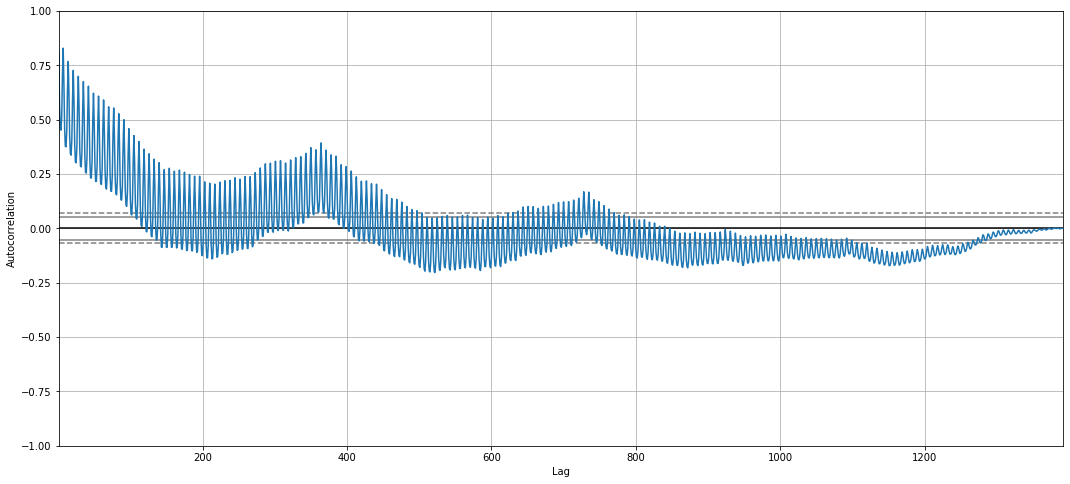

In [197]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y);

##### Y vs Y_pred

Matplotlib

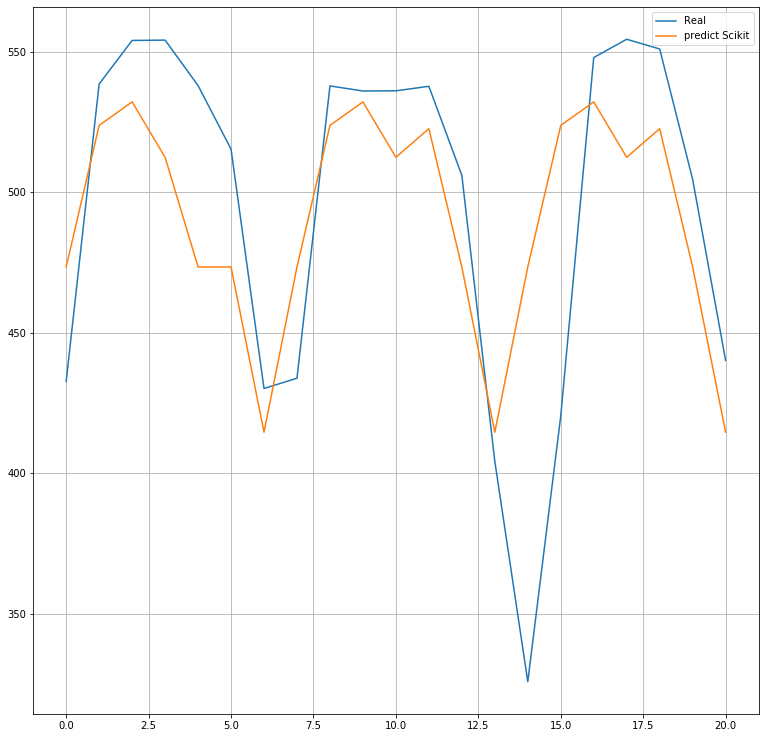

In [200]:
plt.figure(figsize=(13,13))
plt.plot(y[x2].values, label="Real")
# plt.plot(x_test, y_pred2, label="predict1")
plt.plot(y_pred3, label="predict Scikit")
plt.grid(True)
plt.legend()

plt.show()

##### Y vs Y_pred

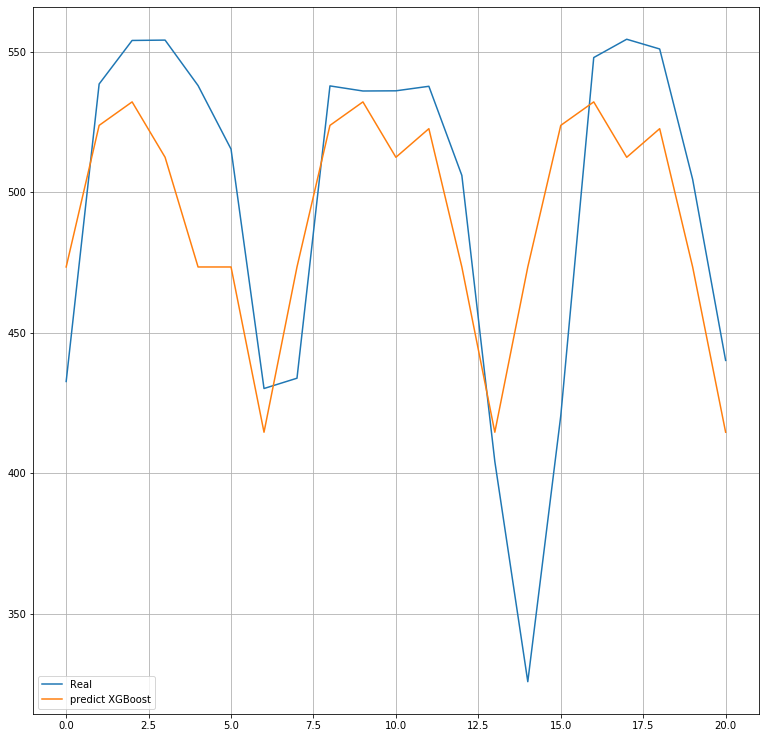

In [151]:
plt.figure(figsize=(13,13))
plt.plot(y[x2].values, label="Real")
plt.plot(y_pred2, label="predict XGBoost")

plt.grid(True)
plt.legend()

plt.show()

Plotly

In [155]:
import plotly.graph_objs as go
from plotly.offline import plot

In [160]:
# Para Scikit-Learn
data1=go.Scatter(x=y.index, y=y.values)
fig=go.Figure(data = data1)
plot(fig)

'temp-plot.html'

In [156]:
# Para Scikit-Learn
t = np.linspace(0, len(y[x2].values), len(y[x2].values))
data1=go.Scatter(x=t, y=y[x2].values)
data2=go.Scatter(x=t, y=y_pred)
fig=go.Figure(data = [data1,data2])
plot(fig)

'temp-plot.html'

In [ ]:
# Para XGBoost
data1=go.Scatter(x=z2.index, y=z2.values)
data2=go.Scatter(x=x2, y=y_pred2)
fig=go.Figure(data = [data1,data2])
plot(fig)